# Afriat

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

In [7]:
torch.cuda.is_available()

False

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
latents_path = [
    "suo_v01_02_tardis_15_latent.h5ad", 
    "suo_v01_02_tardis_30_latent.h5ad", 
    "suo_v01_03_tardis_15_latent.h5ad", 
    "suo_v01_03_tardis_30_latent.h5ad", 
    "suo_v01_04_tardis_15_latent.h5ad", 
    "suo_v01_04_tardis_30_latent.h5ad", 
    "suo_v01_05_tardis_15_latent.h5ad", 
    "suo_v01_05_tardis_30_latent.h5ad", 
    "suo_v02_01_tardis_15_latent.h5ad", 
    "suo_v02_01_tardis_30_latent.h5ad", 
    "suo_v02_02_tardis_15_latent.h5ad", 
    "suo_v02_02_tardis_30_latent.h5ad", 
    "suo_v02_03_tardis_15_latent.h5ad", 
    "suo_v02_03_tardis_30_latent.h5ad", 
    "suo_v02_04_tardis_15_latent.h5ad", 
    "suo_v02_04_tardis_30_latent.h5ad"
]

In [14]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [29]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Suo.h5ad")
adata = ad.read_h5ad(adata_file_path)

In [27]:
!ls -lh /home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent/suo*_latent_subset*

-rw-r--r--. 1 kemal.inecik OG-ICB-User 332M May  1 12:08 /home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent/suo_v01_02_tardis_15_latent_subset-organ.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User 402M May  1 12:08 /home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent/suo_v01_02_tardis_15_latent_subset-unreserved.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User 554M May  1 12:08 /home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent/suo_v01_02_tardis_30_latent_subset-organ.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User 640M May  1 12:08 /home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent/suo_v01_02_tardis_30_latent_subset-unreserved.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User 334M May  1 12:08 /home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent/suo_v01_03_tardis_15_latent_subset-integration_donor.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User 369M May  1 12:09 /home/icb/kemal.inecik/lustre_workspace/tardis_data/_tem

In [43]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "suo_v02_03"
)
vae = tardis.MyModel.load(dir_path=dir_path, adata=adata)

INFO     File /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/suo_v02_03/model.pt already downloaded 


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/model/base/_base_model.py:699: UserWarning: `(None, ['integration_library_platform_coarse'])` is defined as `batch_key` or `categorical_covariate`, it will be given to both encoder and decoder. Make sure this does not contain information of any of your disentenglement targets. For example, if `donor_id` is chosen as a batch key, do not disentengle donor level information such as `sex` or `age`. The decoder should not use the disentengled latent spaces, simply ignores, if it is already given a 

In [48]:
_latent = ad.read_h5ad(os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent", "suo_v02_03_tardis_30_latent.h5ad"))
_latent.obs["validation"] = "train"
_latent.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_4028296/1087311332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _latent.obs["validation"].iloc[vae.validation_indices] = "validation"


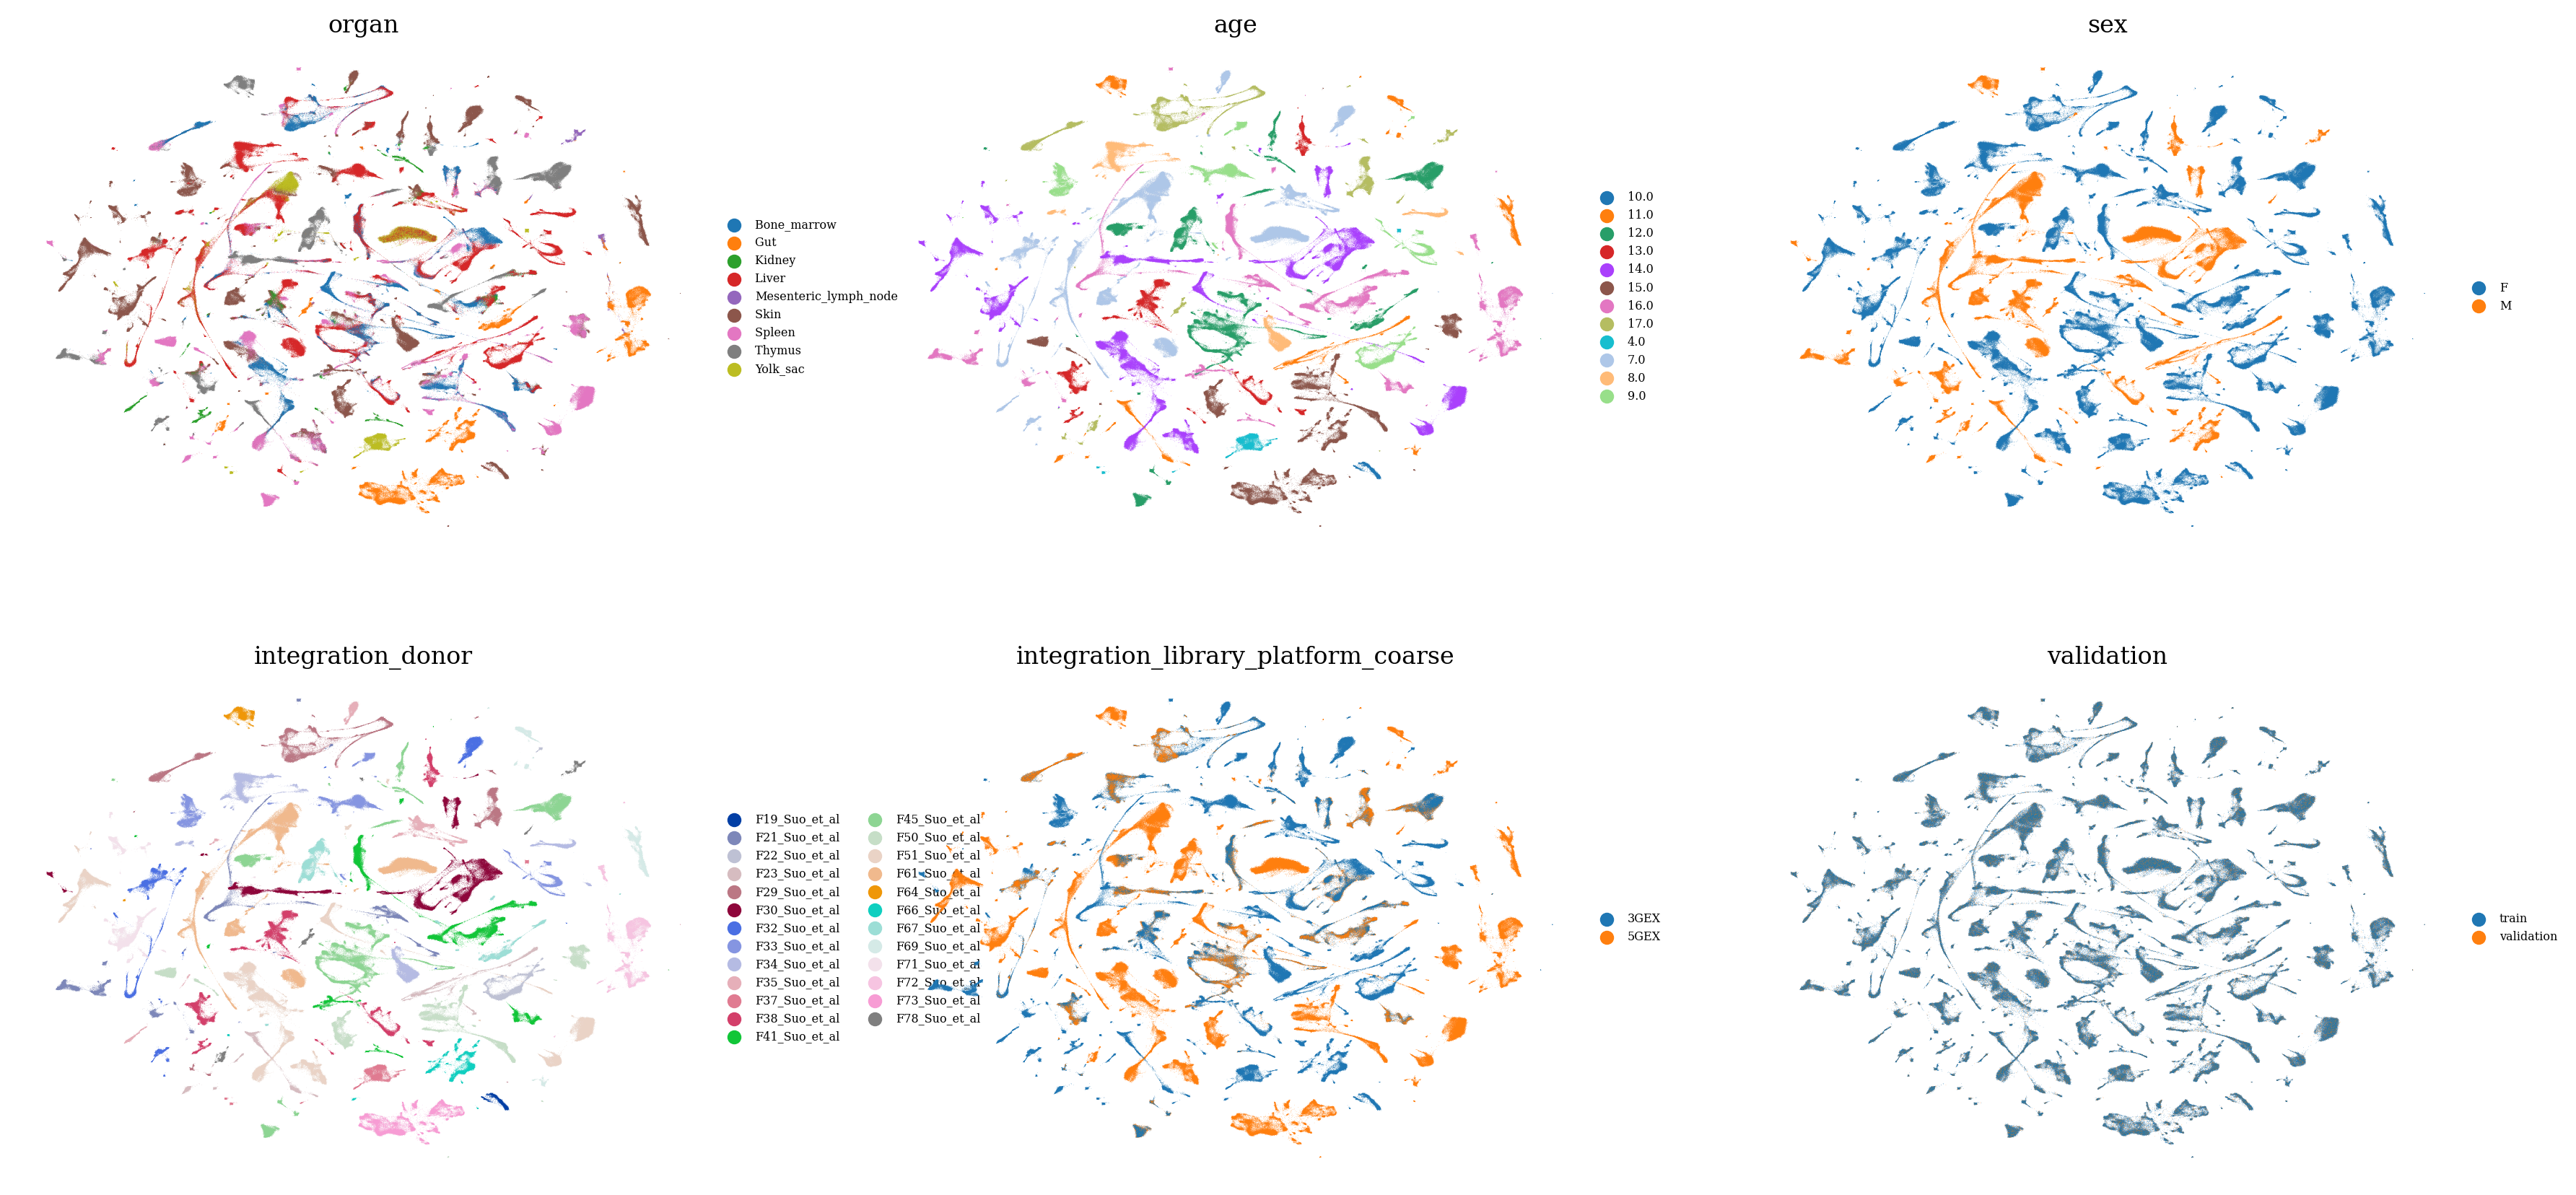

In [49]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        _latent, 
        color=['organ', 'age', 'sex', 'integration_donor', 'integration_library_platform_coarse', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [44]:
_latent = ad.read_h5ad(os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent", "suo_v02_03_tardis_30_latent_subset-integration_donor.h5ad"))
_latent.obs["validation"] = "train"
_latent.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_4028296/1660837776.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _latent.obs["validation"].iloc[vae.validation_indices] = "validation"


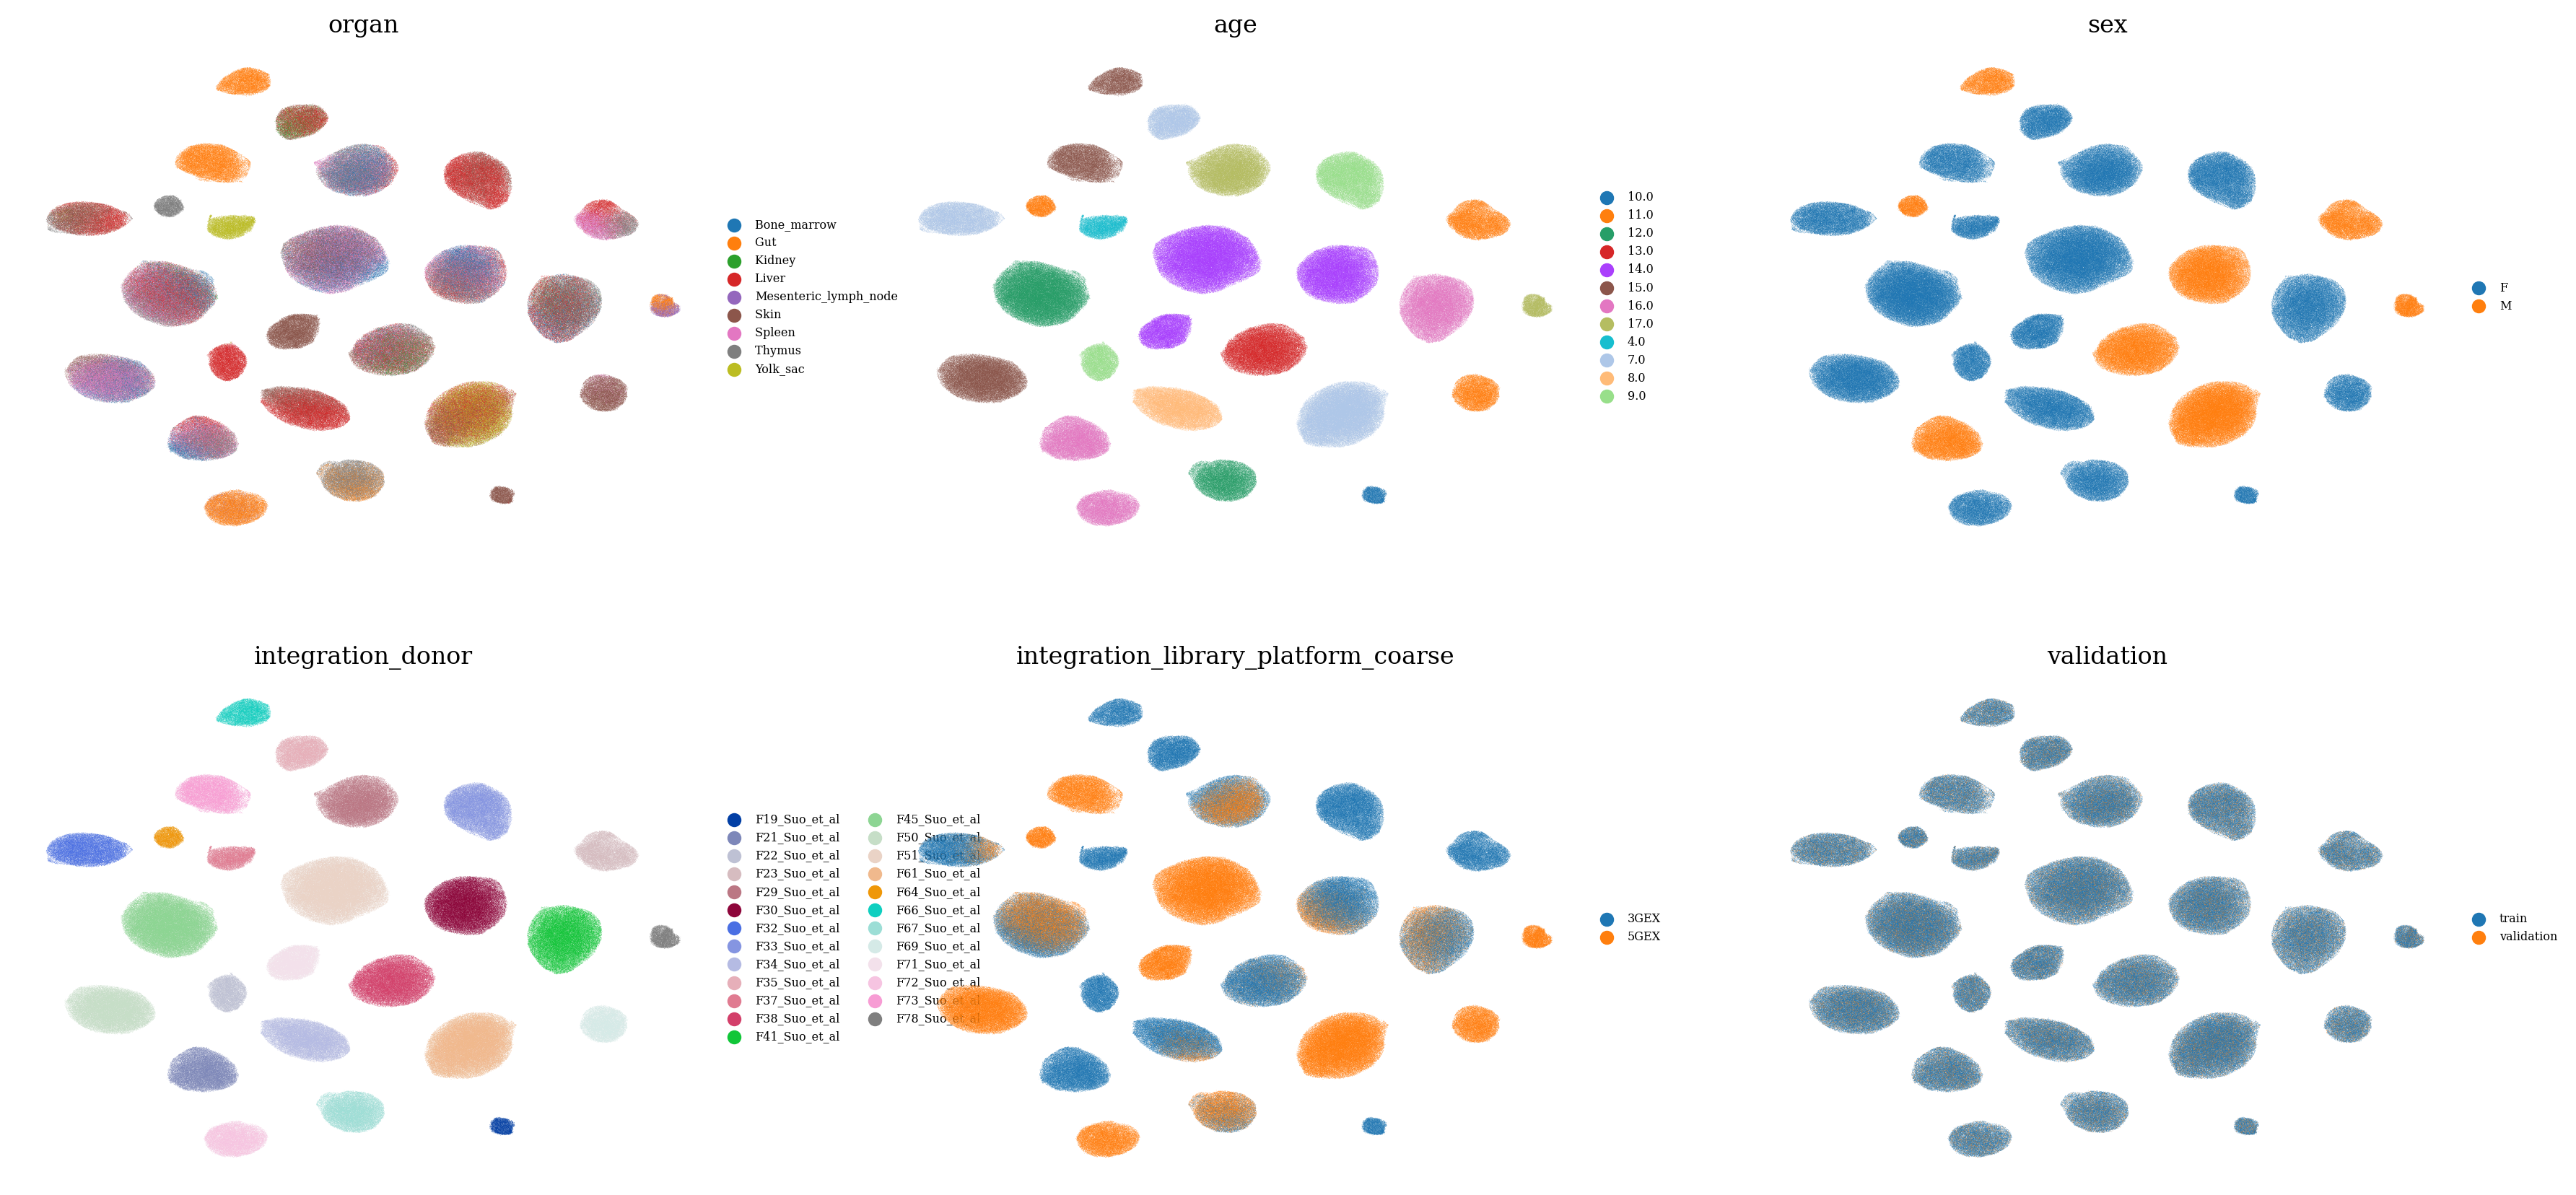

In [45]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        _latent, 
        color=['organ', 'age', 'sex', 'integration_donor', 'integration_library_platform_coarse', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [46]:
_latent = ad.read_h5ad(os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent", "suo_v02_03_tardis_30_latent_subset-unreserved.h5ad"))
_latent.obs["validation"] = "train"
_latent.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_4028296/1699612338.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _latent.obs["validation"].iloc[vae.validation_indices] = "validation"


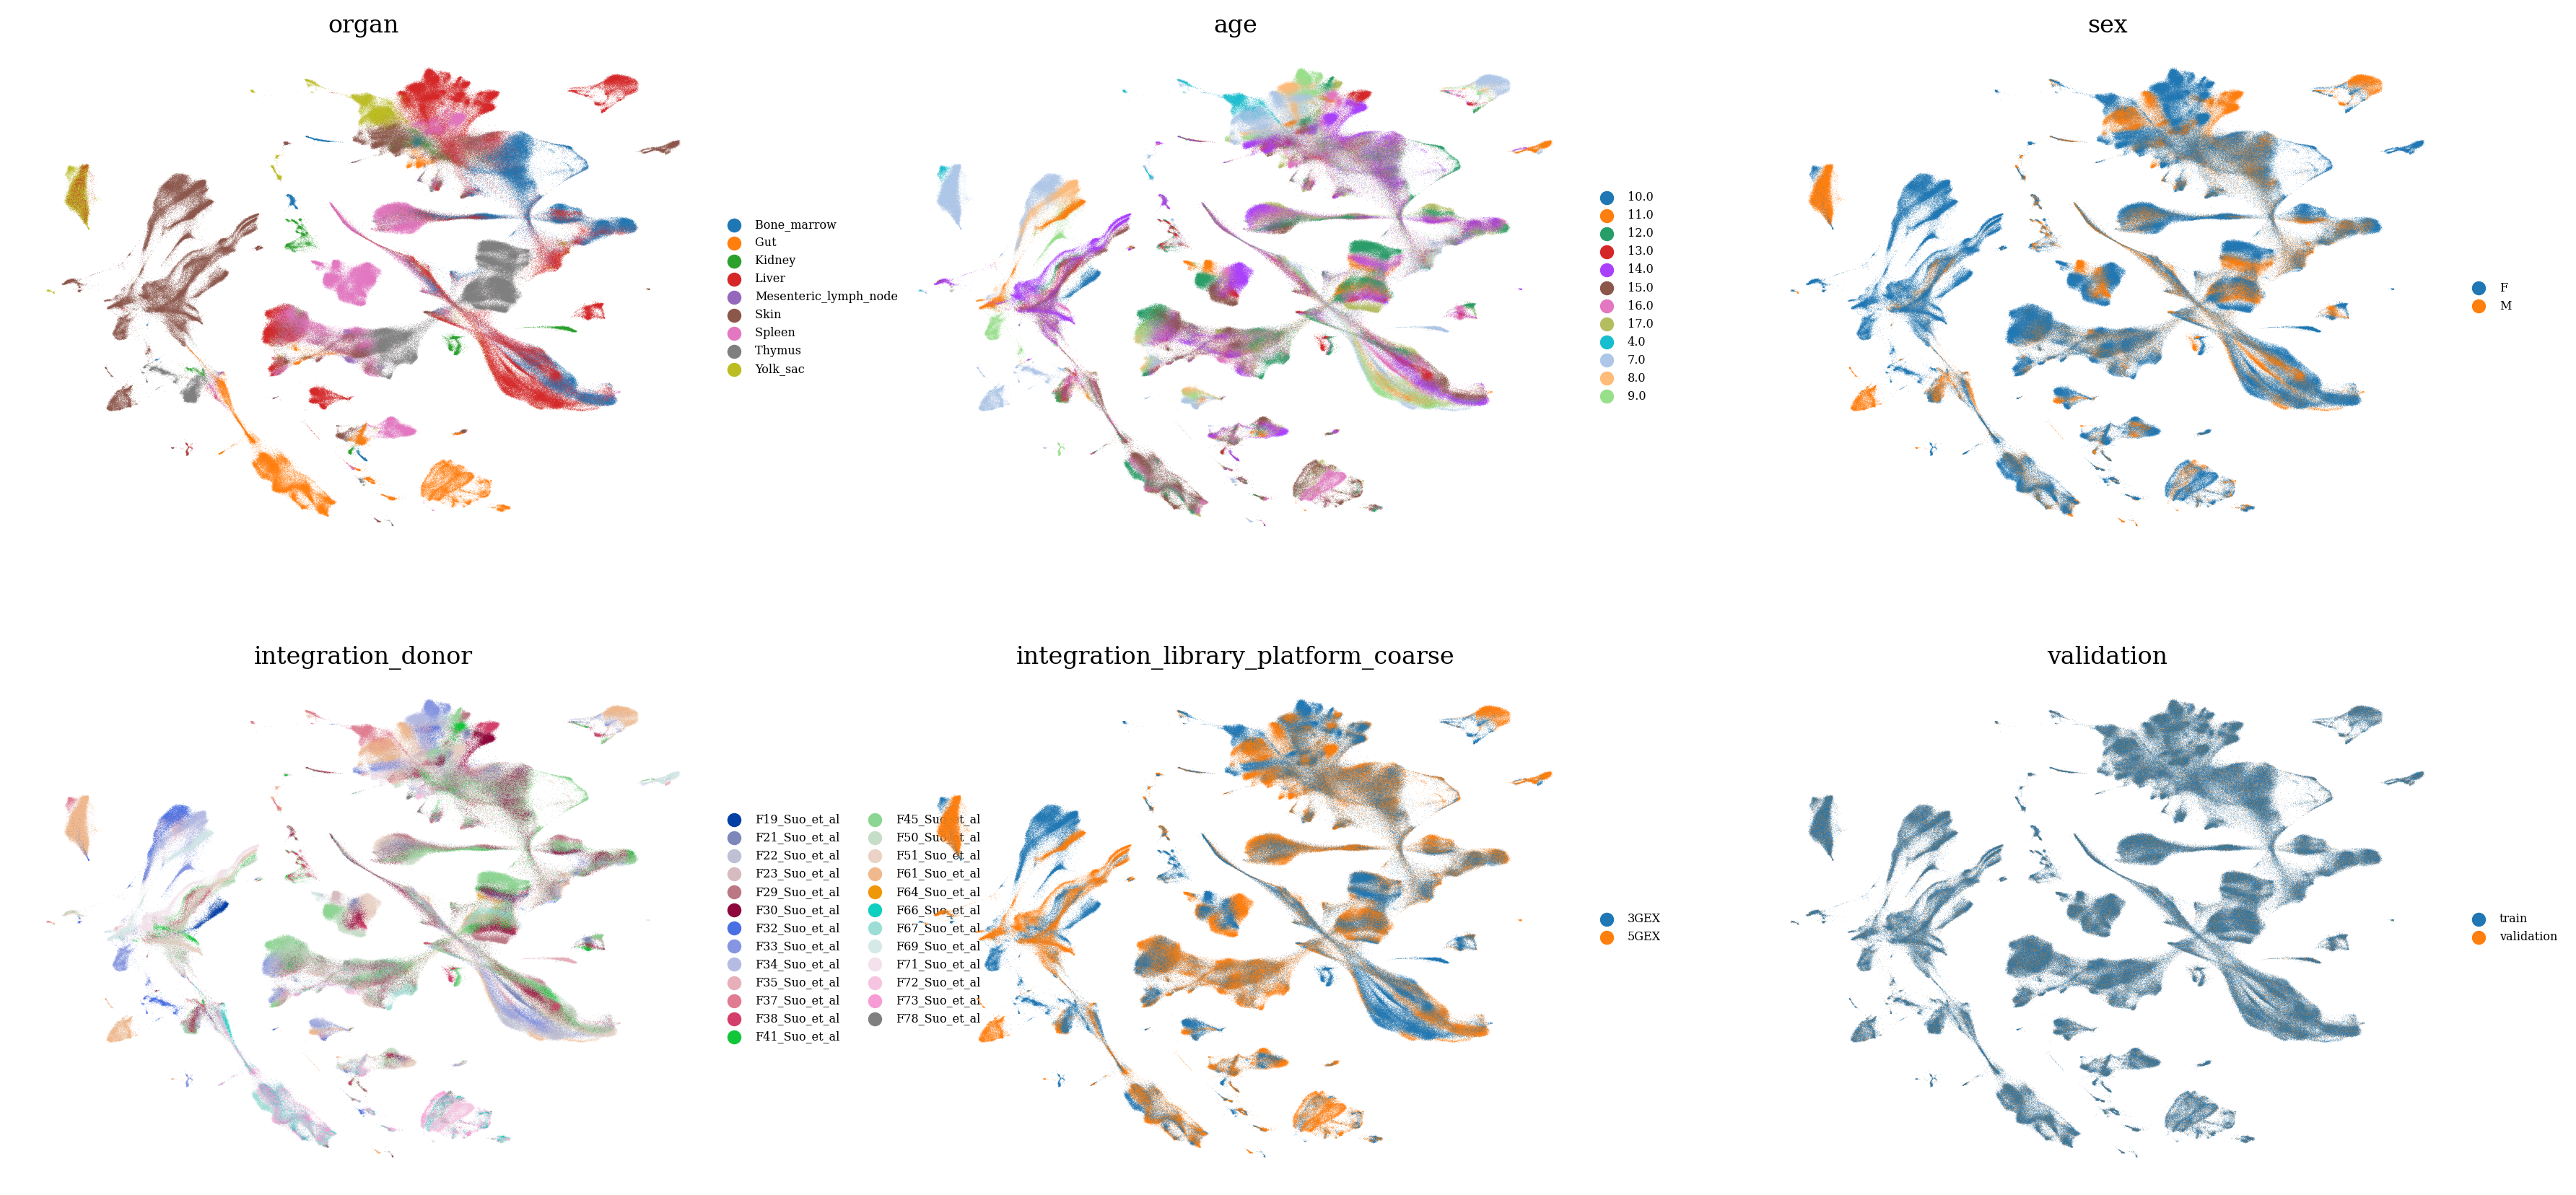

In [47]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        _latent, 
        color=['organ', 'age', 'sex', 'integration_donor', 'integration_library_platform_coarse', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )